In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

Using TensorFlow backend.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df_wdi = pd.read_csv('datasets/world_development_index_clean.csv')

In [6]:
df_wdi.head()

,Country Name,"Birth rate (per 1,000)","Death, by communicable diseases and others (%)","Death, by non-communicable diseases (%)","Health expenditure per capita, PPP ($)","Death rate (per 1,000)","Hospital beds (per 1,000)","International tourism, number of arrivals",Life expectancy at birth (years),"Mortality rate, adult, female (per 1,000)","Mortality rate, adult, male (per 1,000)","Nurses and midwives (per 1,000)",People using at least basic sanitation services (%),Population ages 65+ (%),Population density (people per sq.km),Population,Smoking prevalence (ages 15+)
0,Hungary,9.700,1.8,93.8,1963.162630,13.500,7.000000,17552000.0,76.063415,80.586,168.058,6.6425,97.990873,19.157725,107.906606,9768785.0,30.6
1,Colombia,15.098,10.1,74.8,829.802922,5.503,1.500000,3904000.0,76.925000,87.205,187.406,1.2627,89.625358,8.478047,44.748702,49648685.0,9.0
2,Germany,9.500,4.8,91.2,5463.330652,11.300,8.300000,38881000.0,80.990244,50.173,92.460,13.1967,99.225038,21.461962,237.370970,82927922.0,30.6
3,Slovenia,9.800,5.0,88.4,2772.229776,9.900,4.600000,4425000.0,81.175610,43.961,94.604,9.6800,99.109568,19.606880,102.639860,2067372.0,22.5
4,Rwanda,32.062,42.4,44.0,130.380629,5.308,0.661133,932000.0,68.341000,164.756,219.354,0.8307,66.573842,2.938196,498.659870,12301939.0,12.3


In [7]:
# df = df.join(df_wdi.set_index('Country Name'), on='Country/Region').dropna()

In [8]:
# cols = df.columns[4:]

In [9]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
# df['Population'] = np.array([6.4 *(10**9) for x in range(len(df))])

df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


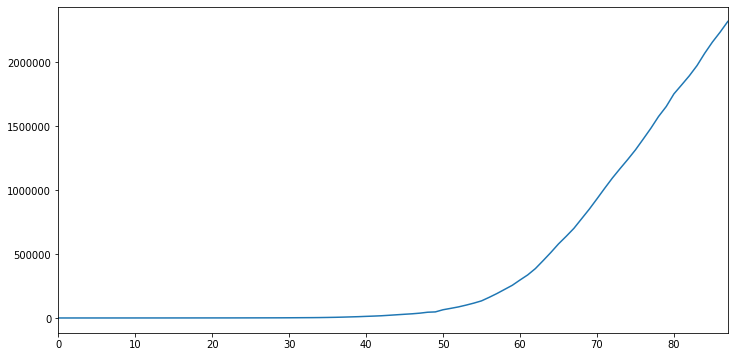

In [10]:
df['Confirmed'].plot(figsize=(12,6))

In [11]:
# df = df.dropna()

In [12]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [13]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [14]:
training_set = df[:train_index]

In [15]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [16]:
training_set_scaled.shape

(70, 1)

In [17]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
print(X_train.shape, y_train.shape)

(50, 20, 1) (50,)


In [19]:
# X_train[0]

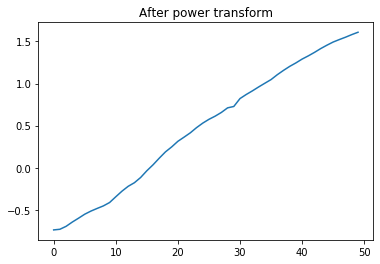

In [20]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [21]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
70,2020-04-02,931034,71
71,2020-04-03,1013406,72
72,2020-04-04,1093517,73
73,2020-04-05,1167152,74
74,2020-04-06,1238816,75


In [22]:
real_conf = testing_set['Confirmed'].values

In [23]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [24]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
# inputs
# total
print(X_test.shape)

(18, 20, 1)


In [26]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [27]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [28]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [29]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7)
cb = [checkpoint, plat]

In [30]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 45 samples, validate on 5 samples
Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 0.642 - 1s 12ms/step - loss: 0.5977 - val_loss: 0.4466
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 0.383 - 0s 2ms/step - loss: 0.3630 - val_loss: 0.2252
Epoch 3/200
45/45 [==============================] - ETA: 0s - loss: 0.342 - 0s 2ms/step - loss: 0.3176 - val_loss: 0.2677
Epoch 4/200
45/45 [==============================] - ETA: 0s - loss: 0.259 - 0s 2ms/step - loss: 0.2608 - val_loss: 0.2401
Epoch 5/200
45/45 [==============================] - ETA: 0s - loss: 0.294 - 0s 3ms/step - loss: 0.2612 - val_loss: 0.1665
Epoch 6/200
45/45 [==============================] - ETA: 0s - loss: 0.221 - 0s 3ms/step - loss: 0.2184 - val_loss: 0.0511
Epoch 7/200
45/45 [==============================] - ETA: 0s - loss: 0.147 - 0s 2ms/step - loss: 0.1387 - val_loss: 0.0960
Epoch 8/200
45/45 [==============================] - ETA: 0s - loss: 0.202 - 0s 3ms/step - loss

45/45 [==============================] - ETA: 0s - loss: 0.069 - 0s 3ms/step - loss: 0.0810 - val_loss: 0.0085

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1.977326610358432e-05.
Epoch 61/200
45/45 [==============================] - ETA: 0s - loss: 0.072 - 0s 3ms/step - loss: 0.0593 - val_loss: 0.0090
Epoch 62/200
45/45 [==============================] - ETA: 0s - loss: 0.048 - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0091
Epoch 63/200
45/45 [==============================] - ETA: 0s - loss: 0.038 - 0s 3ms/step - loss: 0.0397 - val_loss: 0.0095
Epoch 64/200
45/45 [==============================] - ETA: 0s - loss: 0.059 - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0093

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.3841286272509023e-05.
Epoch 65/200
45/45 [==============================] - ETA: 0s - loss: 0.067 - 0s 3ms/step - loss: 0.0775 - val_loss: 0.0087
Epoch 66/200
45/45 [==============================] - ETA: 0s - loss: 0.054 - 0s 3ms/step - loss: 0.0618 -


Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.3410683550318935e-07.
Epoch 117/200
45/45 [==============================] - ETA: 0s - loss: 0.053 - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0030
Epoch 118/200
45/45 [==============================] - ETA: 0s - loss: 0.053 - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0030
Epoch 119/200
45/45 [==============================] - ETA: 0s - loss: 0.044 - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0030
Epoch 120/200
45/45 [==============================] - ETA: 0s - loss: 0.066 - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0030

Epoch 00120: ReduceLROnPlateau reducing learning rate to 9.387478883127187e-08.
Epoch 121/200
45/45 [==============================] - ETA: 0s - loss: 0.039 - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0030
Epoch 122/200
45/45 [==============================] - ETA: 0s - loss: 0.065 - 0s 3ms/step - loss: 0.0555 - val_loss: 0.0030
Epoch 123/200
45/45 [==============================] - ETA: 0s - loss: 0.065 - 0s 3ms/s

Epoch 00172: ReduceLROnPlateau reducing learning rate to 9.095435737904722e-10.
Epoch 173/200
45/45 [==============================] - ETA: 0s - loss: 0.057 - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0030
Epoch 174/200
45/45 [==============================] - ETA: 0s - loss: 0.057 - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0030
Epoch 175/200
45/45 [==============================] - ETA: 0s - loss: 0.064 - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0030
Epoch 176/200
45/45 [==============================] - ETA: 0s - loss: 0.043 - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0030

Epoch 00176: ReduceLROnPlateau reducing learning rate to 6.366804861102082e-10.
Epoch 177/200
45/45 [==============================] - ETA: 0s - loss: 0.047 - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0030
Epoch 178/200
45/45 [==============================] - ETA: 0s - loss: 0.083 - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0030
Epoch 179/200
45/45 [==============================] - ETA: 0s - loss: 0.042 - 0s 2ms/ste

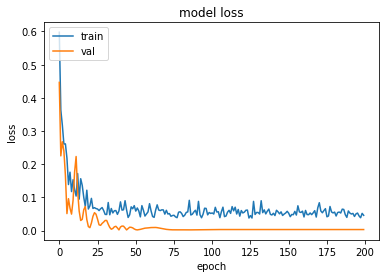

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [32]:
model.load_weights("model.h5")

In [33]:
predicted_conf = model.predict(X_test)

In [34]:
# predicted_conf=pd.DataFrame(predicted_conf)
# X_test[0]

In [35]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[ 931182.06],
       [1010184.7 ],
       [1090012.2 ],
       [1170040.  ],
       [1249064.  ],
       [1325845.9 ],
       [1399926.9 ],
       [1472033.8 ],
       [1542947.2 ],
       [1613783.6 ],
       [1684174.  ],
       [1755131.5 ],
       [1825398.1 ],
       [1893514.  ],
       [1959502.1 ],
       [2024899.5 ],
       [2090382.5 ],
       [2155253.2 ]], dtype=float32)

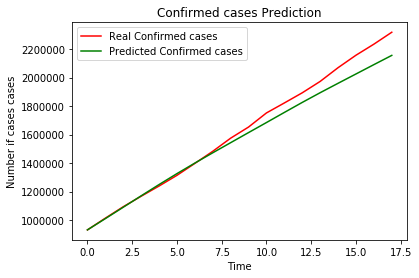

In [36]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [37]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([ 931034, 1013406, 1093517, 1167152, 1238816, 1313758, 1397393,
       1482395, 1574585, 1652636, 1751587, 1821625, 1892885, 1972698,
       2069034, 2156430, 2233971, 2317573], dtype=int64)

In [38]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.03631140458599685


# Use old predictions as input for new predictions

In [39]:
training_set.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [40]:
inp = np.array([X_train[-1]])
inp

array([[[0.7278032 ],
        [0.82182118],
        [0.87003951],
        [0.91332918],
        [0.95980533],
        [1.00388419],
        [1.04740112],
        [1.10508706],
        [1.15650876],
        [1.20416688],
        [1.24541091],
        [1.29096133],
        [1.32917374],
        [1.3709074 ],
        [1.41597616],
        [1.4562036 ],
        [1.49361534],
        [1.52311544],
        [1.55119733],
        [1.58190528]]])

In [41]:
inp_pred = model.predict(inp)

In [42]:
inp_pred[0]

array([1.6109049], dtype=float32)

In [43]:
inp = list(inp[0])
inp.pop(0)

array([0.7278032])

In [44]:
inp.append(inp_pred)
# inp

In [45]:
# np.array([inp])

In [46]:
def gen_pred(inp, num):
    preds = []
    for n in range(num):     
        inp = np.array([inp])
        inp_pred = model.predict(inp) 
        preds.append(list(inp_pred[0]))
        inp = list(inp[0])
        inp.pop(0)
        inp.append(inp_pred)
    return preds


In [47]:
res = gen_pred(X_train[-1], len(real_conf))
# res

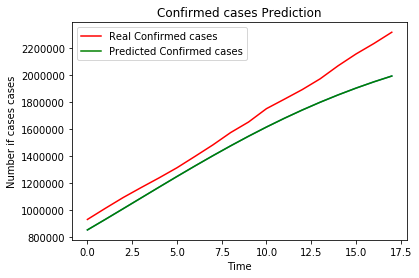

In [48]:
plt.plot(sc.inverse_transform(res))

plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(res), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

plt.show()

In [49]:
print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(sc.inverse_transform(res) + 1) - np.log(real_conf + 1)))))

RMSLE =  0.3870302045848154


# For each country

In [50]:
# pop = pd.read_csv('datasets\population_data.csv')
# pop.head()

In [51]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [52]:
country ='India'

In [53]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0).reset_index()
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
0,1373,India,21.0,78.0,2020-01-30,1
1,1558,India,21.0,78.0,2020-01-31,1
2,1743,India,21.0,78.0,2020-02-01,1
3,1928,India,21.0,78.0,2020-02-02,2
4,2113,India,21.0,78.0,2020-02-03,3


In [54]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
76,15433,India,21.0,78.0,2020-04-15,12322,77
77,15618,India,21.0,78.0,2020-04-16,13430,78
78,15803,India,21.0,78.0,2020-04-17,14352,79
79,15988,India,21.0,78.0,2020-04-18,15722,80
80,16173,India,21.0,78.0,2020-04-19,17615,81


In [55]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [56]:
def create_model():
    model = Sequential()

    model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)
    
    return model

In [57]:
plat = ReduceLROnPlateau(monitor='loss', patience=4, verbose=0, factor=0.7)
cb = [plat]

In [58]:
countries = list(df_c['Country/Region'].unique())
len(countries)

184

In [59]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [60]:
errs = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    training = split
    total = temp.shape[0]
    train_index = int(total*training)
    
    training_set = temp[:train_index]
    
    sc = PowerTransformer(method='yeo-johnson', standardize=True)
    training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))
    
    X_train = []
    y_train = []
    for i in range(window, train_index):
        X_train.append(training_set_scaled[i-window:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping
    if X_train.shape[0] < 1:
        continue
#     print(X_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    testing_set = temp[train_index:]
    testing_set = pd.DataFrame(testing_set)
    
    inputs = temp['Confirmed'][len(temp) - len(testing_set) - window:].values
    # print(inputs)
    inputs = inputs.reshape(-1,1)
    # print(inputs)
    inputs = sc.transform(inputs)
    # print(inputs)
    X_test = []
    for i in range(window, window+(total-train_index)):
        X_test.append(inputs[i-window:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))
    
    model = create_model()
    
    history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
                    verbose = 0)
    
#     predicted_conf = model.predict(X_test)    
#     pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]

    real_conf = np.array(testing_set['Confirmed'].values)
    res = gen_pred(X_train[-1], len(real_conf))
    pred_conf = sc.inverse_transform(res)
    
    rmsle = np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1))))
    
    errs.append([country ,rmsle])
    
    
    

(24, 20)
(13, 20)
(24, 20)
(19, 20)
(4, 20)
(10, 20)
(18, 20)
(20, 20)
(48, 20)
(24, 20)
(20, 20)
(8, 20)
(24, 20)
(14, 20)
(7, 20)
(21, 20)
(40, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(2, 20)
(8, 20)
(16, 20)
(12, 20)
(16, 20)
(23, 20)
(13, 20)
(14, 20)
(12, 20)
(4, 20)
(47, 20)
(16, 20)
(48, 20)
(8, 20)
(5, 20)
(18, 20)
(16, 20)
(8, 20)
(12, 20)
(16, 20)
(12, 20)
(24, 20)
(11, 20)
(13, 20)
(20, 20)
(22, 20)
(38, 20)
(6, 20)
(3, 20)
(20, 20)
(20, 20)
(32, 20)
(5, 20)
(8, 20)
(4, 20)
(22, 20)
(9, 20)
(10, 20)
(5, 20)
(45, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(49, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(9, 20)
(7, 20)
(23, 20)
(47, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(9, 20)
(23, 20)
(3, 20)
(9, 20)
(10, 20)
(11, 20)
(4, 20)
(16, 20)
(12, 20)
(17, 20)
(21, 20)
(44, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(19, 20)
(28, 20)
(24, 20)
(20, 20)
(27, 20)
(44, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(12, 20)
(50, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(18, 20)
(10, 20)
(10, 20)
(50, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(24, 20)
(6, 20)
(1, 20)
(19, 20)
(27, 20)
(8, 20)
(1, 20)
(17, 20)
(21, 20)
(20, 20)
(4, 20)
(48, 20)
(14, 20)
(15, 20)
(9, 20)
(6, 20)
(21, 20)
(14, 20)
(20, 20)
(12, 20)
(7, 20)
(19, 20)
(3, 20)
(9, 20)
(48, 20)
(22, 20)
(21, 20)
(5, 20)
(4, 20)
(21, 20)
(23, 20)
(23, 20)
(24, 20)
(23, 20)
(12, 20)
(4, 20)
(14, 20)
(16, 20)
(44, 20)
(17, 20)
(19, 20)
(20, 20)
(23, 20)
(44, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(9, 20)
(9, 20)
(9, 20)
(22, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(19, 20)
(19, 20)
(16, 20)
(9, 20)
(50, 20)
(16, 20)
(16, 20)
(8, 20)
(16, 20)
(43, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(47, 20)
(10, 20)
(9, 20)
(44, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(24, 20)
(3, 20)
(50, 20)
(8, 20)
(50, 20)
(3, 20)
(16, 20)
(9, 20)
(17, 20)
(12, 20)
(50, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(4, 20)
(18, 20)
(45, 20)
(44, 20)
(9, 20)
(8, 20)
(9, 20)
(50, 20)
(16, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(6, 20)
(4, 20)



In [61]:
# np.array(errs).mean()

In [65]:
# errs

In [63]:
err = pd.DataFrame(errs, columns = ['country', 'error'])

In [66]:
# err.dropna().sort_values(by= 'error')
err.dropna().describe()

,error
count,155.000000
mean,0.434115
std,0.518040
min,0.000715
25%,0.158318
50%,0.299592
75%,0.472026
max,3.964425
